In [1]:
%pylab inline
from scipy.interpolate import interpn
from constant import * 
from multiprocessing import Pool
from functools import partial
import warnings
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


### Value iteration of renting a house

$$V_t(w_t, s_t) = max_{\{c_t, h_t, b_t, k_t\}}\{ u(c_t, h_t) + \beta E[P_t V_{t+1}(w_{t+1}, s_{t+1}) + (1-P_t) u_B(w_{t+1})]\}$$
Subject to:    
$$y_t + w_t = c_t + P_t^r h_t + b_t + k_t$$
$$ w_{t+1} = (1+r_t^f) b_t + (1+r_{t+1}^m) k_t $$    

Shape of the state: $$(100  \times 27)$$
Shape of the actions: $$(20 \times 20 \times 20)$$

In [2]:
#Define the utility function
def u(c):
    return (np.float_power(c, 1-gamma) - 1)/(1 - gamma)

#Define the bequeath function, which is a function of wealth
def uB(tb):
    return B*u(tb)

#Reward function for renting
def u_rent(a):
    '''
    Input:
        action a: c, b, k, h = a 
    Output: 
        reward value: the length of return should be equal to the length of a
    '''
    c = a[:,0]
    h = a[:,3]
    C = np.float_power(c, alpha) * np.float_power(h, 1-alpha)
    return u(C)

def transition_to_rent(x,a,t):
    '''
        imput: a is np array constains all possible actions 
        output: from x = w_t to x = w_{t+1}
    '''
    w, s = x
    s = int(s)
    aSize = len(a)
    # actions taken 
    b = a[:,1]
    k = a[:,2]
    future_states = np.zeros((aSize*nS,2))
    future_states[:,0] = np.repeat(b*(1+r_b[s]), nS) + np.repeat(k, nS)*(1+np.tile(r_k, aSize))
    future_states[:,1] = np.tile(range(nS),aSize)
    future_probs = np.tile(Ps[s],aSize)
    return future_states, future_probs

class Approxy(object):
    def __init__(self, V, pts, t):
        self.V = V 
        self.pts = pts
        self.t = t
    def predict(self, xx):
        # x = [w, s]
        pvalues = np.zeros(xx.shape[0])
        for s in range(nS): 
            index = (xx[:,1] == s)
            pvalues[index]=interpn(self.pts, self.V[:,s], xx[index][:,0], bounds_error = False, fill_value = None)
        return pvalues

In [3]:
# used to calculate dot product
def dotProduct(p_next, uBTB, t):
    return (p_next*uBTB).reshape((len(p_next)//(nS), (nS))).sum(axis = 1)

# value function 
def V(x, t, NN):
    w, s = x
    yat = detEarning[t]
    # first define the objective function solver and then the objective function
    def obj_solver_rent(obj_rent):
        # a = [c, b, k, h] 
        budget1 = yat + w
        h = budget1*actionsP[:,0]/pr
        budget2 = budget1*(1-actionsP[:,0])
        c = budget2*actionsP[:,1]
        budget3 = budget2*(1-actionsP[:,1])
        k = budget3*actionsP[:,2]
        b = budget3*(1-actionsP[:,2])
        actions = np.column_stack((c,b,k,h))
        values = obj_rent(actions)
        fun = np.max(values)
        ma = actions[np.argmax(values)]
        return fun, ma          
    
    
    if t == T_max-1:
        # The objective function of renting
        def obj_rent(actions): 
            # a = [c, b, k, h]
            x_next, p_next  = transition_to_rent(x, actions, t)
            uBTB = uB(x_next[:,0]) 
            return u_rent(actions) + beta * dotProduct(uBTB, p_next, t) 

        fun, action = obj_solver_rent(obj_rent)
        return np.array([fun, action])
    
    else:
        # The objective function of renting
        def obj_rent(actions):
            # a = [c, b, k, h]
            x_next, p_next  = transition_to_rent(x, actions, t)
            V_tilda = NN.predict(x_next) # V_rent_{t+1} used to approximate, shape of x is [w,s]
            uBTB = uB(x_next[:,0])
            return u_rent(actions) + beta * (Pa[t] * dotProduct(V_tilda, p_next, t) + (1 - Pa[t]) * dotProduct(uBTB, p_next, t))

        fun, action = obj_solver_rent(obj_rent)
        return np.array([fun, action])

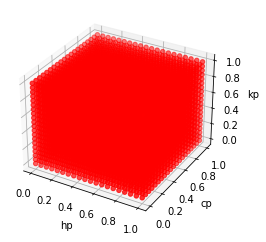

In [4]:
# (hp, cp, kp)
numGrid = 20
actionsP = np.array(np.meshgrid(np.linspace(0.001,0.999,numGrid), np.linspace(0.001,0.999,numGrid), np.linspace(0,1,numGrid))).T.reshape(-1,3)
# visulize if the grids are evenly distributed
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(actionsP[:,0], actionsP[:,1], actionsP[:,2], c='r', marker='o')
ax.set_xlabel('hp')
ax.set_ylabel('cp')
ax.set_zlabel('kp')
plt.show()

In [5]:
# wealth discretization 
# ws = np.array([10,25,50,75,100,125,150,175,200,250,500,750,1000,1500,3000])
ws = np.linspace(10, 100, 100)
w_grid_size = len(ws)
pointsRent = (ws,)
# dimentions of the state
dim = (w_grid_size, nS)
dimSize = len(dim)

xgrid = np.array([[w, s] for w in ws for s in range(nS)]).reshape(dim + (dimSize,))

xs = xgrid.reshape((np.prod(dim),dimSize))

Vgrid = np.zeros(dim + (T_max,))
cgrid = np.zeros(dim + (T_max,))
bgrid = np.zeros(dim + (T_max,))
kgrid = np.zeros(dim + (T_max,))
hgrid = np.zeros(dim + (T_max,))

In [6]:
%%time
# value iteration part 
pool = Pool()
for t in range(T_max-1,T_min, -1):
    print(t)
    if t == T_max - 1:
        f = partial(V, t = t, NN = None)
        results = np.array(pool.map(f, xs))
    else:
        approx = Approxy(Vgrid[:,:,t+1],pointsRent, t+1)
        f = partial(V, t = t, NN = approx)
        results = np.array(pool.map(f, xs))
    Vgrid[:,:,t] = results[:,0].reshape(dim)
    cgrid[:,:,t] = np.array([r[0] for r in results[:,1]]).reshape(dim)
    bgrid[:,:,t] = np.array([r[1] for r in results[:,1]]).reshape(dim)
    kgrid[:,:,t] = np.array([r[2] for r in results[:,1]]).reshape(dim)
    hgrid[:,:,t] = np.array([r[3] for r in results[:,1]]).reshape(dim)
pool.close()

np.save("Vgrid_renting",Vgrid) 
np.save("cgrid_renting",cgrid) 
np.save("bgrid_renting",bgrid) 
np.save("kgrid_renting",kgrid) 
np.save("hgrid_renting",hgrid) 

59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
CPU times: user 15.1 s, sys: 3.17 s, total: 18.3 s
Wall time: 18min 27s


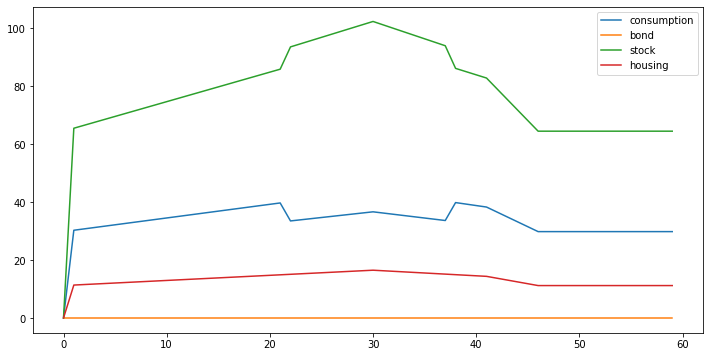

In [13]:
# plot consumption against time 
wealthLevel = 50
econState = 5
plt.figure(figsize = [12,6])
plt.plot(cgrid[wealthLevel,econState,:], label = "consumption")
plt.plot(bgrid[wealthLevel,econState,:], label = "bond")
plt.plot(kgrid[wealthLevel,econState,:], label = "stock")
plt.plot(hgrid[wealthLevel,econState,:]*pr, label = "housing")
legend()